In [20]:
import torch
import matplotlib.pyplot as plt
from PIL import Image

import random
from pathlib import Path

In [5]:
# Load the DRIVE dataset
dataset = Path('data/DRIVE')

# Load the training dataset
train_images = sorted(dataset.glob('training/images/*.tif'))
train_labels = sorted(dataset.glob('training/1st_manual/*.gif'))
train_mask = sorted(dataset.glob('training/mask/*.gif'))

In [18]:
train_images[:3], train_labels[:3], train_mask[:3]

([PosixPath('data/DRIVE/training/images/21_training.tif'),
  PosixPath('data/DRIVE/training/images/22_training.tif'),
  PosixPath('data/DRIVE/training/images/23_training.tif')],
 [PosixPath('data/DRIVE/training/1st_manual/21_manual1.gif'),
  PosixPath('data/DRIVE/training/1st_manual/22_manual1.gif'),
  PosixPath('data/DRIVE/training/1st_manual/23_manual1.gif')],
 [PosixPath('data/DRIVE/training/mask/21_training_mask.gif'),
  PosixPath('data/DRIVE/training/mask/22_training_mask.gif'),
  PosixPath('data/DRIVE/training/mask/23_training_mask.gif')])

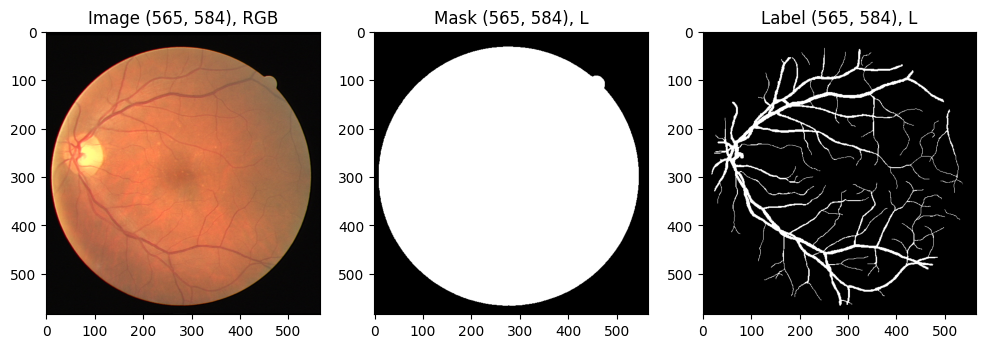

In [26]:
# Display a sample image, mask and label
image = Image.open(train_images[0])
mask = Image.open(train_mask[0])
label = Image.open(train_labels[0])

plt.figure(figsize=(12, 8))
plt.subplot(131)
plt.imshow(image)
plt.title(f'Image {image.size}, {image.mode}')
plt.subplot(132)
plt.imshow(mask, cmap='gray')
plt.title(f'Mask {mask.size}, {mask.mode}')
plt.subplot(133)
plt.imshow(label, cmap='gray')
plt.title(f'Label {label.size}, {label.mode}')
plt.show()


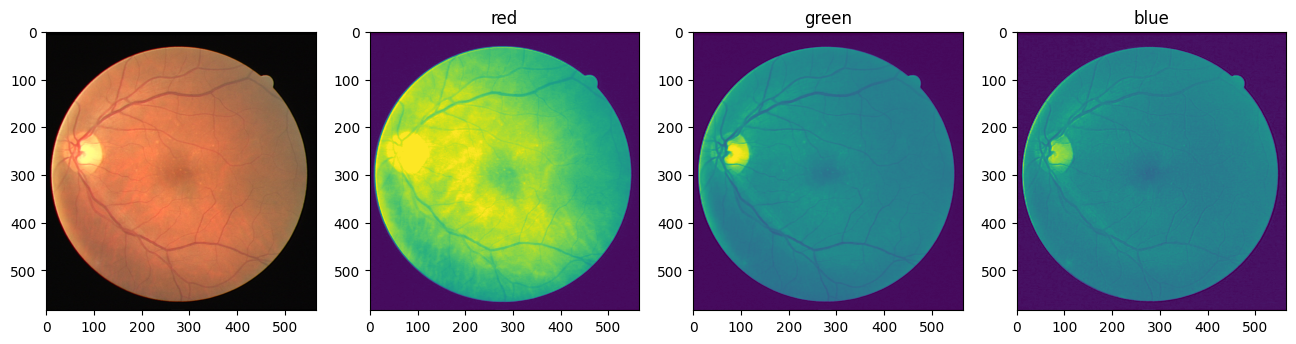

In [31]:
# Displaying the image in R,G,B channels
red, green, blue = image.split()

plt.figure(figsize=(16, 8))
plt.subplot(141)
plt.imshow(image)
plt.subplot(142)
plt.imshow(red)
plt.title('red')
plt.subplot(143)
plt.imshow(green)
plt.title('green')
plt.subplot(144)
plt.imshow(blue)
plt.title('blue')
plt.show()

In [40]:
# Preprocessing training images

# 1. take only the green channel
# 2. apply morphological opening with a three-pixel diameter disk structuring element
# 3. The local background gray level is computed by applying a 69×69 mean filter to the image. The
# background is then subtracted and the resulting gray levels are scaled from 0 to 1.
# 4. a constant is added to the image gray levels so the mode gray level value in image is set to 0.5
# 5.  top-hat transformation on the complement of the image using an eight-pixel radius
# disk as the structuring element
# 

import numpy as np
from skimage import morphology
from skimage import exposure
from skimage import filters
from skimage import img_as_float
from skimage import transform

def preprocess(image, mask):
    # Convert the image and mask to float32 tensors
    image = img_as_float(image)
    mask = img_as_float(mask)
    
    # Take only the green channel
    image = image[:, :, 1]
    
    # Apply morphological opening with a 3-pixel disk structuring element
    selem = morphology.disk(3)
    image = morphology.opening(image, selem)
    
    # Compute the local mean of the image
    local_mean = filters.rank.mean(image, selem)
    
    # Subtract the local mean from the image
    image = image - local_mean
    
    # Scale the image so that its values range from 0 to 1
    image = exposure.rescale_intensity(image)
    
    # Add a constant to the image so that its minimum value is 0
    image = image - image.min()
    
    # Normalize the image so its values sum to 1
    image = image / image.sum()
    
    # Apply a top-hat transformation to the image
    selem = morphology.disk(8)
    image = morphology.white_tophat(image, selem)
    
    # Normalize the image so its values sum to 1
    image = image / image.sum()
    
    # Apply the mask to the image
    image = image * mask
    
    # Convert the image and the mask to PyTorch tensors
    image = torch.from_numpy(image).unsqueeze(0)
    mask = torch.from_numpy(mask).unsqueeze(0)
    
    return image

/var/folders/6p/sy3vktvj7ls4vmvwmgttgfr00000gn/T/ipykernel_5019/2032361085.py:1: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  p_image = preprocess(image, mask)


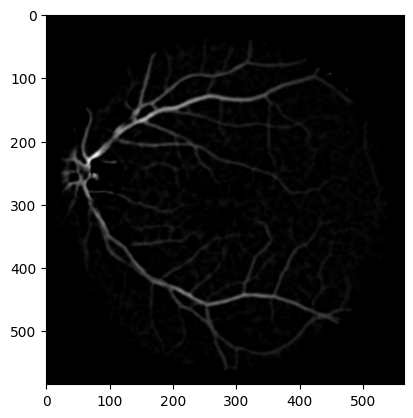

In [41]:
p_image = preprocess(image, mask)
plt.imshow(p_image[0], cmap='gray')

# Sampling the training set